## Import libraries and data

In [7]:
# Import libraries

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt


# Load data
path = r'data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col = None, header = 1)
    list_.append(df)
frame = pd.concat(list_)



['data/LoanStats_2016Q3.csv', 'data/LoanStats_2016Q2.csv', 'data/LoanStats_2016Q1.csv', 'data/LoanStats_2016Q4.csv', 'data/LoanStats3d.csv', 'data/LoanStats_2017Q1.csv', 'data/LoanStats_2017Q3.csv', 'data/LoanStats_2017Q2.csv', 'data/LoanStats3b.csv', 'data/LoanStats3c.csv', 'data/LoanStats3a.csv', 'data/LoanStats_2017Q4.csv']


/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=comp

## Clean data and add useful variables

In [8]:
# Change interest rate to float
frame['int_rate'] = frame['int_rate'].str.rstrip('%').astype('float') / 100.0

# Cast emp_length to int
def emp_length_to_int(s):
    return max([int(n) for n in str(s).split() if n.isdigit()] + [0])
frame['emp_length_num'] = frame['emp_length'].apply(emp_length_to_int)

# Add late and default dummies
is_late_16_30 = lambda s: int(s == "Late (16-30 days)")
is_late_31_120 = lambda s: int(s == "Late (31-120 days)")
is_default = lambda s: int(s == "Default")

frame['late_16_30'] = frame.loan_status.apply(is_late_16_30)
frame['late_31_120'] = frame.loan_status.apply(is_late_31_120)
frame['default'] = frame.loan_status.apply(is_default)

# Add interest-to-total-received and late-fees-to-total-received ratios
frame['int_to_total'] = frame['total_rec_int'] / frame['total_pymnt']
frame['late_fees_to_total'] = frame['total_rec_late_fee'] / frame['total_pymnt']

## Plot loan grade distributions

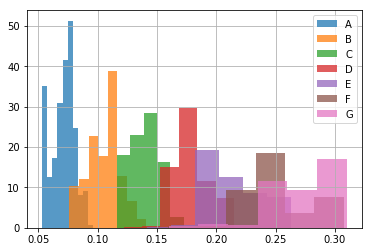

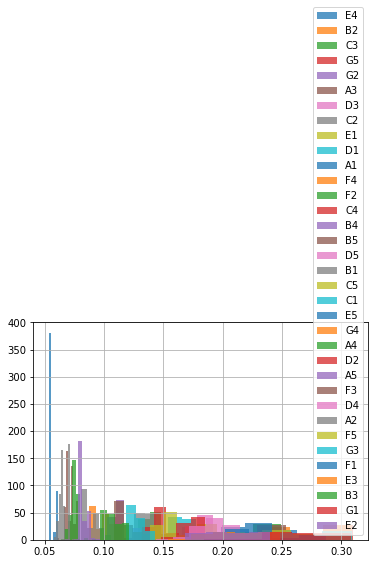

In [9]:
# Plot distribution of interest rates for each loan grade

for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    subset = frame['grade'] == grade
    frame['int_rate'][subset].hist(label = grade, normed = True, alpha = 0.75)

plt.legend()
plt.show()

# Plot distribution of interest rates for each loan subgrade

for sub_grade in {sg for sg in set(frame['sub_grade']) if sg == sg}:
    subset = frame['sub_grade'] == sub_grade
    frame['int_rate'][subset].hist(label = sub_grade, normed = True, alpha = 0.75)

plt.legend()
plt.show()